In [1]:
include("tools.jl");

WebIO._IJuliaInit()

  Activating project at `~/gits/ApxThyApp/nb`


# §1 Approximation with Trigonometric Polynomials

## §1.1 Introduction

Trigonometric polynomials are functions of the form
$$
t_N(x) = \sum_{k = -N}^N c_k e^{i k x}
$$
Alternatively, we may write this as 
$$
	t_N(x) = a_0 + \sum_{k = 1}^N \Big( a_k \cos(k x) + b_k \sin(k x) \Big),
$$
but we will always use the much more convenient complex exponential notation. 

Note that $t_N$ will be $2\pi$-periodic, i.e. we are now restricting ourselves to approximating periodic functions. But in return we gain a cleaner and simpler theory. Further, everything we do applies to some extent also to algebraic polynomials.

$N$ is called the degree of $t_N$. The space of all trigonometric polynomials of degree $N$ is denoted by 
$$
\mathcal{T}_N := {\rm span}\big\{ x \mapsto \exp(i k x ) \,|\, k  = -N, \dots, N \big\}.
$$


Remember we said that approximation theory is about approximating complex functions with simple functions. Are trigonometric polynomials "simple" ? In other words, is $e^{i k x}$ straightforward to implement? If $z = e^{i x}$ is available then we can obtain $e^{i k x} = z^k$ just by multiplication. Implementing $e^{i x}$ is not difficult either, e.g., we can use a truncated Taylor series; see the exercise 1.1.1. But there are much more efficient implementations using rational functions. We will not pursue this but just accept that somebody has done that job for us.

### Function classes

The widest possible class of target functions $f$ we will be concerned with are continuous functions, i.e., functions belonging to the space 
$$
  C_{\rm per} := \big\{ f : \mathbb{R} \to \mathbb{R} \,|\, \text{ continuous, and } 2\pi\text{-periodic} \big\}.
$$
Technically we could go to classes of integrable functions, $L^p$, but this leads to further technicalities that less interesting.

We will assume higher regularity later on, such as differentiability of certain order, analyticity, etc. But for now it is only important for us to know that all $f$ we encounter have well-defined point values. 

The natural norm on $C_{\rm per}$ is the max-norm (or, sup-norm, or $L^\infty$-norm), 
$$
    \| f \|_\infty := \max_{x \in [-\pi, \pi]} |f(x)|.
$$
This is also a natural measure for the approximation error: throughout this course we will focus on understanding approximation errors in this norm, i.e., given a function $f \in C_{\rm per}$ we aim to construct an approximation $t_N \in \mathcal{T}_N$ such that 
$$
   \|f - t_N \|_\infty 
$$
is small, and to understand the rate of this error as $N \to \infty$. 

Another very natural measure of the error is the $L^2$-norm, $\|f\|_2 := (\int_{-\pi}^\pi |f|^2 \,dx)^{1/2}$, which we will explore in §3 on least squares methods. 


## § 1.2 Trigonometric Interpolation

A general degree $N$ trigonometric polynomial, 
$$
   t_N(x) = \sum_{k = -N}^N c_k e^{i k x}
$$
has $2N+1$ parameters $c_{-N}, \dots, c_N$. How should we determine these? It would be ideal if we can prescribe exactly $2N+1$ conditions. A natural and general approach is *interpolation*: given a target function $f \in C_{\rm per}$ we demand that 
$$ 
	t_N(x_j) = f(x_j), \qquad j = 0, \dots, 2N
$$
where $x_j$ are called the interpolation nodes. 

How should they be chosen? It turns out  that equi-spaced nodes work very well. An intuitive justification for this choice is that in a periodic domain, all parts of the domain are "equal" and should be treated the same. By contrast in a finite interval one should *not* use equispaced nodes, but rather cluster them at the boundary (cf. Chebyshev interpolation [LN, Ch. 4]). Thus, we may choose the interpolation nodes
$$
	x_j = \frac{\pi j}{N}, \qquad j = 0, \dots, 2N.
$$
(Note we could equally use equispaced notes on $[-\pi, \pi]$ which often feels more natural, but the convention for certain algorithms -- see below -- is to use the nodes defined above.)


Because of the periodic boundary condition the nodes $x_0 = 0, x_{2N} = 2\pi$ are "equivalent", in the sense that $f(x_0) = f(x_{2N})$, which is clearly a bad idea! A possibly way forward is to use instead the nodes $\frac{2\pi j}{2N+1}, j= 1, \dots, 2N+1$. This might work (I haven't actually tested it!) but for algorithmic reasons it turns out that a much more convenient decision is to keep the nodes we defined above, but change the space of polynomials.

Namely, consider the two basis functions $e^{iNx}$ and $e^{-iNx}$. What values do they take on the grid? 
$$
   e^{i N x_j} = e^{i N j \pi/N}  = e^{i\pi j} 
  = (-1)^j = (-1)^{-j} = e^{-i \pi j} = e^{- i N \pi j/N} = e^{- i N x_j}.
$$
That is, these two basis functions are identical on the grid. In other words we have found the kernel of the interpolation operator on the equispaced grid. There are multiple possible solution, but a simple one is to replace these basis functions with their mean, i.e. 
$$
	\frac{e^{i N x} + e^{-i N x}}{2} = \cos(N x),
$$
which of course takes again the same values on the grid. This results in a modified trigonometric polynomial space which contains the range of the interpolation operator, 
$$
	\mathcal{T}_N' := {\rm span} \Big( \mathcal{T}_{N-1} \cup \{ \cos(Nx) \} \Big)
$$

**Theorem:** The nodal interpolation operator $I_N : C_{\rm per} \to \mathcal{T}_N'$ is well-defined, i.e., for all $f \in C_{\rm per}$ there exists a unique $I_N f := t_N \in \mathcal{T}_N$ such that 
$$
	t_N(x_j) = f(x_j) \qquad \text{for } j = 1, \dots, 2N.
$$

**Proof:** Straightforward exercise, e.g., a simple way to prove it is that it can be reduced to algebraic polynomial interpolation in $\mathbb{C}$. It will also follow from results we will cover later.

#### Implementation Notes

* To define the nodal interpolation operator we setup a linear system that specifies the coefficients. If $I_N f(x) = \sum_{k = -N+1}^{N-1} \hat{F}_k e^{i k x} + \hat{F}_N \cos(Nx)$ then 
$$
	\sum_{k = -N+1}^N \hat{F}_k e^{i k x_j} = F_j \qquad \text{for } j = 0, \dots, 2N-1,
$$
where $F_j = f(x_j)$ and $\hat{F}_k$ are the coefficients. Knowing the coefficients we can then evaluate the interpolant.
* Since $e^{i N x} = \cos(Nx)$ on the interpolation nodes, it doesn't matter which of the two we use to construct the interpolation operator.
* The ordering of the basis is in principle arbitrary. Here we use a convention used for fast algorithms (FFT), 
$$
	(0, 1, \dots, N, -N+1, -N+1, \dots, -1)
$$
This may look strange at first, but see more on this below!


In [2]:
"interpolation nodes"
xgrid(N) = range(0, 2*π - π/N, length = 2*N)

"fourier coefficient indices"
kgrid(N) = [0:N; -N+1:-1]
;

In [3]:
let N = 3
    # implement the nodal interpolation operator 
    A = [ exp(im * k * x) for k in kgrid(N), x in xgrid(N) ]
    # observe that A'A ~ diagonal
    real.(round.(A' * A, digits=12))
    # confirm it is an orthogonal matrix (up to scaling)! I.e. (A'/2N) = inv(A) !!
    # norm(A' * A - 2*N*I)
end

6×6 Matrix{Float64}:
  6.0  -0.0   0.0   0.0  -0.0   0.0
 -0.0   6.0  -0.0  -0.0   0.0  -0.0
  0.0  -0.0   6.0   0.0   0.0  -0.0
  0.0  -0.0   0.0   6.0  -0.0   0.0
 -0.0   0.0   0.0  -0.0   6.0   0.0
  0.0  -0.0  -0.0   0.0   0.0   6.0

In addition to guaranteeing that $I_N$ is well-defined we also see that the matrix $A$ we need to invert is orthogonal (up to rescaling), which makes it very easy to invert it. We just need to multiply by $A^H$, i.e. $O(N^2)$ computational cost instead of $O(N^3)$ for solving a full linear system via [Gaussian elimination](https://en.wikipedia.org/wiki/LU_decomposition).

These two operations $F \mapsto \hat{F}$ and $\hat{F} \mapsto F$ are called the discrete and inverse discrete fourier transforms. They can in fact be applied with $O(N \log(N))$ computational cost, using the *fast fourier transform*. We will study this later but for now use our naive implementation.


In [4]:
"""
construct the coefficients of the trigonometric interpolant
"""
function triginterp(f, N)
    X = xgrid(N)
    # nodal values at interpolation nodes
    F = f.(X) 
    # system matrix
    A = [ exp(im * x * k) for k in kgrid(N), x in X ]
    # coefficients are given by F̂ = A' * F as discussed above!
    return (A' * F) / (2*N)
end 


"""
to evaluate a trigonometric polynomial just sum coefficients * basis
we the take the real part because we assume the function we are 
approximating is real.
"""
evaltrig(x, F̂) = sum( real(F̂k * exp(im * x * k))
                      for (F̂k, k) in zip(F̂, kgrid(length(F̂) ÷ 2)) )


evaltrig

We are now ready to study some examples. Here is a selection of different functions we may want to approximate:
$$
\begin{aligned}
f_1(x) &= \sin(x) \\
f_2(x) &= \sin(4x) \\
f_3(x) &= |\sin(2x)| \\
f_4(x) &= |\sin(2x)|^3 \\
f_5(x) &= \exp(\cos(x)) \\
f_6(x) &= \frac{1}{1 + \sin(x)^2} \\
f_7(x) &= \frac{1}{1 + 10*\sin(x)^2} \\
f_8(x) &= \chi_{|x| < 2.5}  \exp\bigg(3 - \frac{3}{1-(x/2.5)^2}\bigg)
\end{aligned}
$$

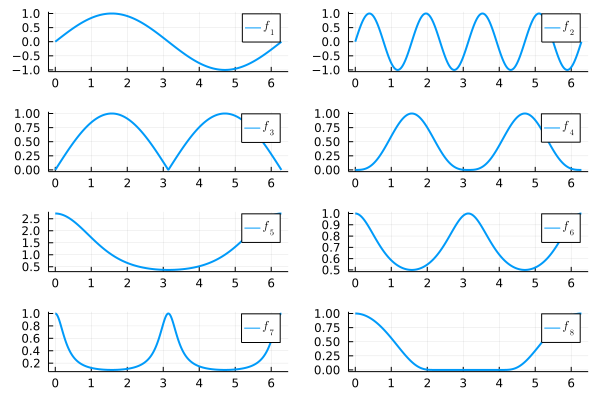

In [5]:
f1(x) = sin(x)
f2(x) = sin(4*x)
f3(x) = abs(sin(x))
f4(x) = abs(sin(x))^3
f5(x) = exp(cos(x))
f6(x) = 1 / (1 + sin(x)^2)
f7(x) = 1 / (1.0 + 10*sin(x)^2)
g8(x) = x^2 < 2.49999^2 ? exp(3 - 3 / (1-(x/2.5)^2)) : 0.0
f8(x) = g8(mod(x+π,2*π)-π)

allf = [f1, f2, f3, f4, f5, f6, f7, f8]
flabels = latexstring.(["f_$n" for n in 1:8])

xx = range(0, 2π, length=500)
Ps = [ plot(xx, f.(xx), label = flabels[n], lw=2) 
       for (n, f) in enumerate(allf) ]
plot(Ps..., layout = (4,2))

We can just visually play around a bit with different target functions and degrees.....

In [17]:
# play with the functions and with the parameters! 
# if `Interact.jl` doesn't work for you, then replace the 
# @manipulate line with the let line and manually change 
# the parameters. 
# let fidx = 5, N = 7
@manipulate for fidx = 1:8, N = 3:30
    f = allf[fidx]
    X = xgrid(N)
    xp = range(0, 2π, length=200)
    F̂ = triginterp(f, N)
    plot(xp, f.(xp), lw=6, label = latexstring("f_{$fidx}"), size = (450, 250))
    plot!(xp, evaltrig.(xp, Ref(F̂)), lw=3, label = latexstring("I_{$N} f"))
    plot!(X, f.(X), lw=0, m=:o, ms=4, c = 2, label = "", 
         legend = :outertopright)
    title!(latexstring("\\mathrm{Trigonometric~Interpolant:} I_{$N} f_$fidx"))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["fidx"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 8, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
4, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/ortner/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/ortner/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/ortner/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/Users/ortner/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/Users/ortner/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000298300740, Task (runnable) @0x0000000298300740), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"15537371134822439440\",\"id\":\"4096522378093041506\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"15537371134822439440\",\"i

....but this is not very informative. We need a more disciplined approach to measuring accuracy and evaluating the quality of the approximation scheme.

We will now study how the errors $\| f - t_N \|_\infty$ behave asymptotically as $N \to \infty$. This asymptotic behavious is called the *convergence rate*.

In [7]:
"""
implementation of a basic error function: 
returns an approximation to the max-norm error
of the trigonometric interpolant, by taking the 
maximum on `Nerr` equispaced sample points
(kwarg)
"""
function triginterperror(f, N; Nerr = 1_362)
    xerr = range(0, 2π, length=Nerr)    # compute error on this grid
    F̂ = triginterp(f, N)                # trigonometric interpolant
    return norm(f.(xerr) - evaltrig.(xerr, Ref(F̂)), Inf)  # max-error on xerr grid
end;

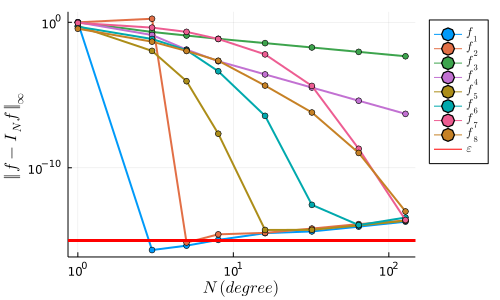

In [8]:
let NN = [1:2:5; (2).^(3:7)], flist = allf, flabels = flabels
    P = plot( xaxis  = (L"N~{\rm (degree)}", ),
              yaxis  = (:log, L"\Vert f - I_N f ~\Vert_{\infty}"), 
              legend = :outertopright, 
              xscale = :log10, yscale = :log10, 
              size = (500, 300))
    for (f, lab) in zip(flist, flabels)
        err = triginterperror.(f, NN)
        plot!(P, NN, err, lw=2, m=:o, ms=3, label = lab)
    end
    hline!(P, [1e-15], c = :red, lw=3, label = L"\epsilon")
end 


Straight lines on a log-log scale correspond to an *algebraic rate of convergence* 
and the slope tells us what the rate is:
$$
    \log({\rm err}(N)) \sim p \log(N)
    \qquad \Leftrightarrow  \qquad 
    {\rm err}(N) \sim N^p
$$

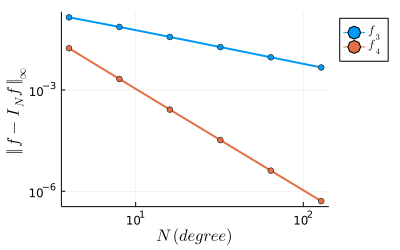

In [9]:
let NN = (2).^(2:7), flist = allf[[3,4]], flabels = flabels[[3,4]]
    P = plot( xaxis  = (L"N~{\rm (degree)}", ),
              yaxis  = (:log, L"\Vert f - I_N f ~\Vert_{\infty}"), 
              legend = :outertopright, 
              xscale = :log10, yscale = :log10, 
              size = (400, 250))
    for (f, lab) in zip(flist, flabels)
        err = triginterperror.(f, NN)
        plot!(P, NN, err, lw=2, m=:o, ms=3, label = lab)
    end
    P
end 


Sublinear behaviour on a log-log plot means super-algebraic convergence. There are many examples of that kind, but the simplest (and typical) is exponentioal convergence, 
$$
    {\rm err}(N) \sim e^{- \alpha N}
    \qquad \Leftrightarrow \qquad 
    \log({\rm err}(N)) \sim - \alpha N
$$
i.e. the "rate" $\alpha$ can be seen on a lin-log plot.

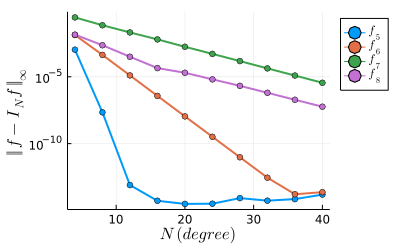

In [10]:
let NN = 4:4:40, flist = allf[5:8], flabels = flabels[5:8]
    # check f8 by switching to NN = 10:10:100
    P = plot( xaxis  = (L"N~{\rm (degree)}", ),
              yaxis  = (:log, L"\Vert f - I_N f ~\Vert_{\infty}"), 
              legend = :outertopright, 
              yscale = :log10, 
              size = (400, 250))
    for (f, lab) in zip(flist, flabels)
        err = triginterperror.(f, NN)
        plot!(P, NN, err, lw=2, m=:o, ms=3, label = lab)
    end
    P
end 

## § 1.4 Approximation Error Estimates

We have seen how to construct trigonometric polynomial approximants and have observed several different kinds of convergence behaviour. Our last goal for the first set of lectures is to explain these observations rigorously. This material is contained in my lecture notes (with further references to the literature). I won't reproduce it here in much detail, but only summarize the main results.

### § 1.4.1 Best approximation and near-best approximation

We will momentarily formulate several results in terms of *best approximation*, i.e., we will show results along the lines 
$$
   \inf_{t_N \in \mathcal{T}_N} \|f - t_N \|_\infty \leq \epsilon_N,
$$
where $\epsilon_N$ is some rate of convergence. Or equivalently, *there exist $t_N \in \mathcal{T}_N$ such that* $\| f - t_N\|_\infty \leq \epsilon_N$. But it will not be clear from those results how to construct such best or quasi-best approximants.

Here, a general principle comes into play that saves us: Let $I_N f$ denote the degree-$N$ trigonometric interpolant of $f$, then one can prove that 
$$
	\| I_N f \|_\infty \leq \Lambda_N \| f \|_\infty \qquad \forall f \in C_{\rm per}
$$
The constant $\Lambda_N$ is called the Lebesgue constant and can be precisely estimated:

**Theorem:** $\Lambda_N \leq \frac{2}{\pi} \log(N+1) + 1$.

**Proof:** See [LN, Thm 3.26] for a proof of a slightly weaker result. The proof is not difficult but quite dry, involving delicate estimates of the Dirichlet kernel. Please study this for further reading.

In practise we will just write $\Lambda_N \lesssim \log N$. With this in hand we have the following argument at our disposal: Let $t_N \in \mathcal{T}_N'$ be *any* trigonometric polynomial, then $I_N t_N = t_N$, and hence, 
$$
\begin{aligned}
	\|f - I_N f \|_\infty 
	&\leq
	\|f - t_N\|_\infty + \| t_N - I_N f \|_\infty \\ 
    &= \|f - t_N\|_\infty + \| I_N (t_N - f) \|_\infty \\ 
	&\leq (1 + \Lambda_N) \|f - t_N \|_\infty.
\end{aligned}
$$
Now, taking the infimum over all $t_N \in \mathcal{T}_N'$ we obtain that 
$$
   \|f - I_N f \|_\infty \leq (1+\Lambda_N) \inf_{t_N \in \mathcal{T}_N'} \|f - t_N \|_\infty.
$$
Thus, the interpolation error is within a $\log N$ factor of the best approximation error. In practise this cannot be observed, and indeed in some scenarios this factor can indeed be removed entirely. Because it is so mild, we won't worry about it. 

**Remark:** The foregoing argument is extremely general. The only property that we used here is that the interpolation operator $I_N : C_{\rm per} \to \mathcal{T}_N'$ is a bounded operator with respect to the $\|\cdot\|_\infty$ norm. It is therefore easy to generalize and indeed used extensively throughout numerical analysis.


### § 1.4.2 Jackson Theorems [LN, Ch. 3]

A function $f \in C_{\rm per}$ has modulus of continuity $\omega : \mathbb{R} \to \mathbb{R}$ if 
$$
|f(x) - f(x')| \leq \omega(|x - x'|) \qquad \forall x, x' \in \mathbb{R}.
$$

**First Jackson Theorem:** If $f \in C_{\rm per}$ has modulus of continuity $\omega$, then there exists $t_N \in \mathcal{T}_N$ such that 
$$
	\| f - t_N \|_\infty \omega(N^{-1}).
$$

The second Jackson theorem extends the result to functions that are continuously differentiable. We say that $f \in C^p_{\rm per}$ if $f \in C_{\rm per}$, is $p$ times continuously differentiable on $\mathbb{R}$ and all derivatives up to $f^{(p)} \in C_{\rm per}$. 

**Second Jackson Theorem:** Assume that $f \in C_{\rm per}^p$ and $f^{(p)}$ has modulus of continuity $\omega$, then there exists $t_N \in \mathcal{T}_N$ such that 
$$
	\| f - t_N \|_\infty N^{-p} \omega(N^{-1}).
$$

A few comments and special cases:
* The smoother $f$ the faster the convergence.
* These results are qualitatively sharp, i.e. Jackson's construction has the optimal rate for these function classes.
* If $f$ is Lipschitz then $\omega(r) = L r$ where $L$ is the Lipschitz constant. An example of a Lipschitz continuous function is $f(x) = |\sin(x)|$. 
* If $f$ is $\sigma$-Hölder then $\omega(r) = C r^\sigma$. An example of a Hölder continuous function is $f(x) = |\sin(x)|^\sigma$. 

We can now explain the first set of numerical results: 
* $f_3$ is Lipschitz continuous, hence the rate is $N^{-1}$
* $f_4 \in C^2$ with $f_4''$ Lischitz hence the rate is $N^{-3}$

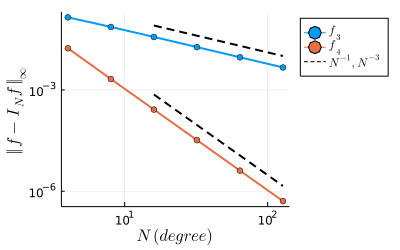

In [11]:
let NN = (2).^(2:7), flist = allf[[3,4]], flabels = flabels[[3,4]]
    P = plot( xaxis  = (L"N~{\rm (degree)}", ),
              yaxis  = (:log, L"\Vert f - I_N f ~\Vert_{\infty}"), 
              legend = :outertopright, 
              xscale = :log10, yscale = :log10, 
              size = (400, 250))
    for (f, lab) in zip(flist, flabels)
        err = triginterperror.(f, NN)
        plot!(P, NN, err, lw=2, m=:o, ms=3, label = lab)
    end
    nn = NN[3:end]
    plot!(nn, 1.3*nn.^(-1), lw=2, c=:black, ls=:dash, label = L"N^{-1}, N^{-3}")
    plot!(nn, 3*nn.^(-3), lw=2, c = :black, ls=:dash, label = "")
    P
end 

We should also extend our tests to go beyond just the Lipschitz case and see if we can reproduce other kinds of convergence behaviour.

In [12]:
# let 
#     f(x) = 
#     rate(N) = 
#     xp = range(-pi, pi, length=200)
#     P1 = plot(xp, f.(xp); lw=3, label = "f(x)")
    
#     NN = (2).^(2:7)
#     err = triginterperror.(f, NN)
#     P2 = plot( NN, err, lw=2, m=:o, ms=3, label = "error", 
#                xaxis  = (L"N~{\rm (degree)}", ),
#                yaxis  = (:log, L"\Vert f - I_N f ~\Vert_{\infty}"), 
#                legend = :topright, 
#                xscale = :log10, yscale = :log10, )

#     nn = NN[3:end]
#     plot!(P2, nn, 1.3*rate.(nn), lw=2, c=:black, ls=:dash, 
#           label = "predicted")

#     plot(P1, P2, size = (550, 300))
# end 


### § 1.4.3 Paley Wiener Theorems [LN, Sec. 2.3 and 3.4]

First we review some standard results of complex analysis that we cannot reproduce here in detail. They will be covered in any introductory textbook or lecture notes on complex analysis.

A function $f : \mathbb{R} \to \mathbb{R}$ is called analytic in a point $x_0$ if it is represented by a Taylor series, i.e., 
$$
	f(x) = \sum_{n = 0}^\infty c_n (x - x_0)^n
$$
and the series has radius of convergence $r > 0$. If $f \in C_{\rm per}$ is analytic in $[-\pi, \pi]$ (and hence in all of $\mathbb{R}$) then using the Taylor series one can extend it to a function on a strip in the complex plane: Let 
$$
\Omega_\alpha := \{ z \in \mathbb{C} : |{\rm Im} z| < \alpha \}
$$
then there exists $\alpha > 0$ and unique analytic $f : \Omega_\alpha \to \mathbb{C}$ which agrees with the original $f$ in $\mathbb{R}$. 

**Payley Wiener Theorem:** Let $f \in C_{\rm per}$ have an analytic extension to $\bar{\Omega}_\alpha$, then 
$$
	f(x) = \sum_{k \in \mathbb{Z}} \hat{f}_k e^{i k x} 
	\qquad \text{with} \qquad |\hat{f}_k| \leq M_\alpha e^{- \alpha |k|}
$$
where $M_\alpha = \sup_{z \in \bar{\Omega}_\alpha} |f(z)|$.

**Corollary:**  Let $f \in C_{\rm per}$ have an analytic extension to $\bar{\Omega}_\alpha$, then there exists $t_N \in \mathcal{T}_N$ such that 
$$
	\|f - t_N\|_\infty \leq M_\alpha e^{-\alpha N}
$$

The most important question for us is "what is the maximal extension"? I.e., what is the largest value $\alpha$ such that $f$ can be extended to an analytic function in $\Omega_\alpha$? We will study this on the two examples $f_6, f_7$.


We are now ready to explain the remaining numerical results: 

* $f_5$ is entire, i.e., the error is bounded by $C_\alpha e^{-\alpha N}$ for all $\alpha > 0$. This is called *superexponential* convergence. 

* $f_8 \in C^\infty$ but is not analytic. The point where it becomes zero has a Taylor expansion that evaluates to zero and hence has a zero convergence radius.

* $f_6, f_7$ are both analytic. To determine the region of analyticity of a function $(1+c^2 \sin^2(x))^{-1}$ we simply need to find where it has a pole.

Use this slider to adjust the parameter $c \in [1, 20]$ in the target function $1 / (1+ c \sin^2(z))$. 

In [13]:
# let c = 1.0
@manipulate for c = 1:20
    f = z -> 1 / (1 + c * sin(z)^2)
    xp = range(-π, π, length=200)
    yp = range(-2, 2, length=200)
    contourf(xp, yp, (x,y) -> log(abs(f(x + im * y))), 
            xlabel = L"x = Re(z)", ylabel = L"y = Im(z)", size = (500, 400),
            title = latexstring("|(1+ $c \\sin^2(z))^{-1}|"), 
            levels=30) 
            # levels=-6.0:0.3:4.1)
    hline!([0.0, asinh(1/sqrt(c)), - asinh(1/sqrt(c))], lw=2, c=:red, label = L"\mathbb{R}, \pm \alpha")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["c"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 20, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
10, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/ortner/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/ortner/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/ortner/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/Users/ortner/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/Users/ortner/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000298dda290, Task (runnable) @0x0000000298dda290), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"14283676341544607831\",\"id\":\"2513798105122168812\",\"type\":\"observable\"})

To carry this out rigorously we need to solve $c^2 \sin^2(z) = -1$, where $c = 1$ for $f_6$ and $c = \sqrt{10}$ for $f_7$. Thus we need to solve
$$
	\sin(z) = \pm \frac{i}{c}
$$
This is not difficult but needs a bit of complex analysis. With a bit of work one can prove that the poles occur at 
$$
	z = n \pi \pm i  \sinh^{-1}(1/c) \sim n\pi \pm i \frac{1}{c} \qquad \text{as } c \to \infty.
$$
This gives us the *open* region of analyticity $\Omega_\alpha$ with $\alpha = \sinh^{-1}(1/c)$. To apply the Paley Wiener theorem we need to make $\alpha$ just a little bit smaller, and we get 
$$
	\| f - t_N \|_\infty \leq C_\epsilon e^{ - (\alpha - \epsilon) N } \qquad \forall \epsilon > 0.
$$
But in practise we just ignore this $\epsilon$ correction:

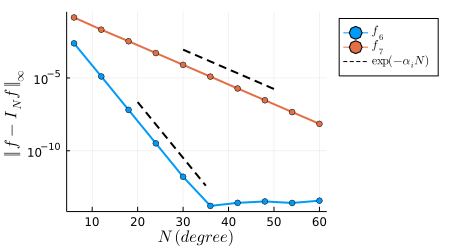

In [14]:
let NN = 6:6:60, flist = allf[6:7], flabels = flabels[6:7]
    P = plot( xaxis  = (L"N~{\rm (degree)}", ),
              yaxis  = (:log, L"\Vert f - I_N f ~\Vert_{\infty}"), 
              legend = :outertopright, 
              yscale = :log10, 
              size = (450, 250))
    for (f, lab) in zip(flist, flabels)
        err = triginterperror.(f, NN)
        plot!(P, NN, err, lw=2, m=:o, ms=3, label = lab)
    end
    nn1 = [20, 35]; nn2 = [30, 50]
    plot!(nn1, 10*exp.( - asinh(1.0) * nn1), lw=2, ls=:dash, c=:black, label = L"\exp(-\alpha_i N)")
    plot!(nn2, 10*exp.( - asinh(1/sqrt(10.0)) * nn2), lw=2, ls=:dash, c=:black, label = "")
end 

In [15]:
# let 
#     f(x) = real(sqrt(0.1 + im * sin(x)))
#     rate(N) = 
#     xp = range(-pi, pi, length=200)
#     P1 = plot(xp, f.(xp); lw=3, label = "f(x)")
    
#     NN = 20:20:200
#     err = triginterperror.(f, NN)
#     P2 = plot( NN, err, lw=2, m=:o, ms=3, label = "error", 
#                xaxis  = (L"N~{\rm (degree)}", ),
#                yaxis  = (:log, L"\Vert f - I_N f ~\Vert_{\infty}"), 
#                legend = :topright, yscale = :log10, )

#     nn = NN[4:end]
#     plot!(P2, nn, rate.(nn), lw=2, c=:black, ls=:dash, 
#           label = "predicted")

#     plot(P1, P2, size = (550, 300))
# end 

This completes our first set computational experiments: 
* trigonometric polynomials
* interpolation with trigonometric polynomials
* rates of convergence 
* implementation and numerical investigation of convergence rates
* summary of rigorous results (Jackson, Paley-Wiener)
* matching theory and numerical results

The next topics will be 
* fast evaluation of the trigonometric interpolant via the fast fourier transform
* numerical solution of BVPs and and IBVPs using trigonometric polynomials (aka spectral methods)
